In [2]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
actions = [
    '감사합니다',
    '사랑합니다',
    '안녕하세요'
]

data = np.concatenate([
    np.load('dataset/seq_감사합니다.npy'),
    np.load('dataset/seq_사랑합니다.npy'),
    np.load('dataset/seq_안녕하세요.npy')
], axis=0)

data.shape

(1175, 30, 226)

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1175, 30, 225)
(1175,)


In [5]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1175, 3)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1057, 30, 225) (1057, 3)
(118, 30, 225) (118, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                74240     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 76419 (298.51 KB)
Trainable params: 76419 (298.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200


31/34 [==========================>...] - ETA: 0s - loss: 0.4176 - acc: 0.8438
Epoch 1: val_acc improved from -inf to 0.99153, saving model to models\model.h5
34/34 [==============================] - 3s 28ms/step - loss: 0.3975 - acc: 0.8515 - val_loss: 0.0649 - val_acc: 0.9915 - lr: 0.0010
Epoch 2/200
 5/34 [===>..........................] - ETA: 0s - loss: 0.0597 - acc: 0.9750

c:\Users\junseok\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/34 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9924
Epoch 2: val_acc did not improve from 0.99153
34/34 [==============================] - 1s 27ms/step - loss: 0.0273 - acc: 0.9924 - val_loss: 0.0559 - val_acc: 0.9831 - lr: 0.0010
Epoch 3/200
33/34 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9839
Epoch 3: val_acc did not improve from 0.99153
34/34 [==============================] - 1s 35ms/step - loss: 0.0377 - acc: 0.9839 - val_loss: 0.0235 - val_acc: 0.9831 - lr: 0.0010
Epoch 4/200
32/34 [===========================>..] - ETA: 0s - loss: 0.0088 - acc: 0.9951
Epoch 4: val_acc improved from 0.99153 to 1.00000, saving model to models\model.h5
34/34 [==============================] - 1s 31ms/step - loss: 0.0087 - acc: 0.9953 - val_loss: 9.0798e-04 - val_acc: 1.0000 - lr: 0.0010
Epoch 5/200
33/34 [============================>.] - ETA: 0s - loss: 0.1396 - acc: 0.9555
Epoch 5: val_acc did not improve from 1.00000
34/34 [=====================

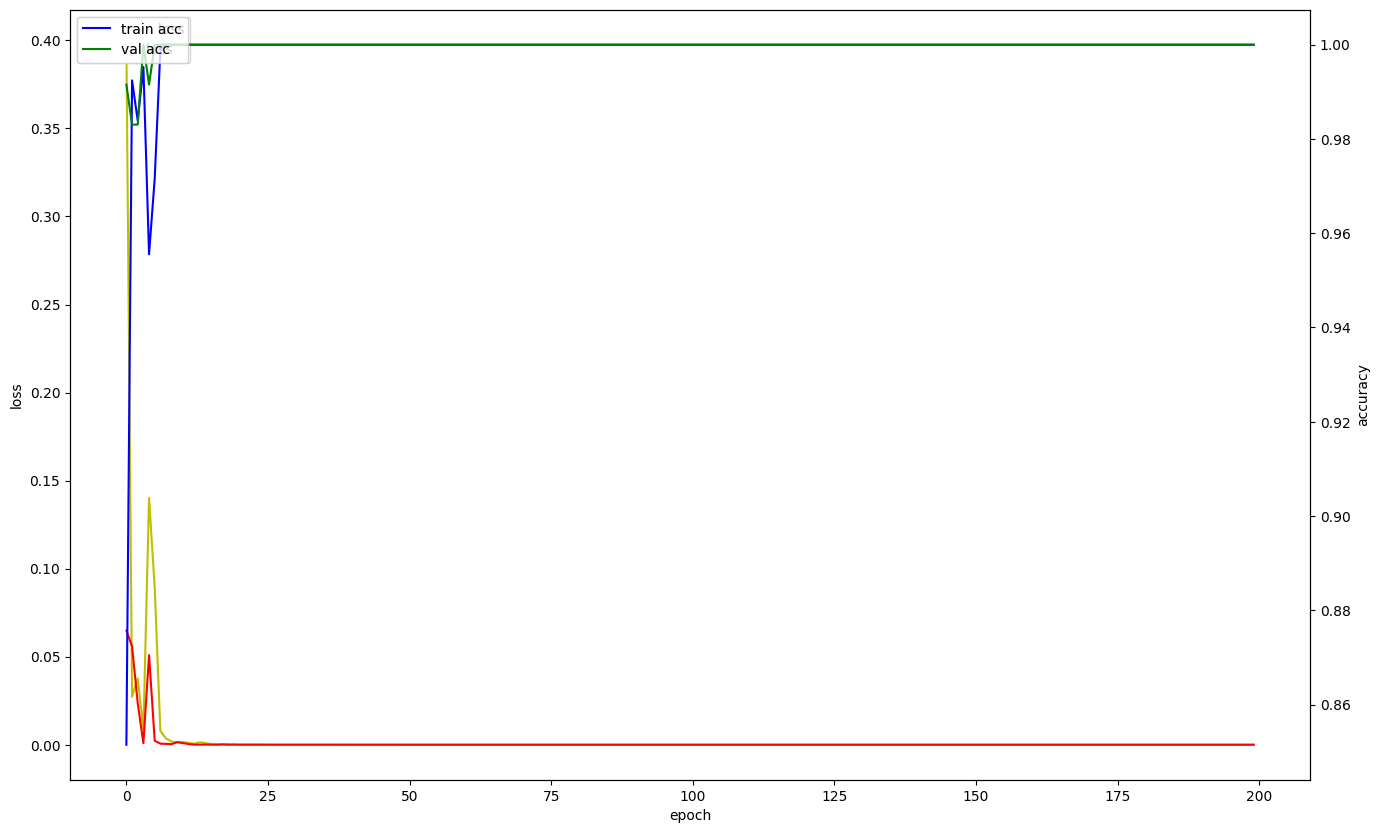

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

4/4 [==============================] - 0s 7ms/step


array([[[84,  0],
        [ 0, 34]],

       [[75,  0],
        [ 0, 43]],

       [[77,  0],
        [ 0, 41]]], dtype=int64)